In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import sys
!{sys.executable} -m pip install jinja2

# QUESTO INSTALL xlrd, openpyxl all'interno del virtualenv
# FONDAMENTALE!!!!
#

!{sys.executable} -m pip install xlrd
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install seaborn



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import os
import seaborn as sns; sns.reset_orig()

plt.style.use('ggplot')

WORKDIR = "csv/"
EXT = '.csv'
VOL_AVG_PERIOD = 20

In [3]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


### Importo la lista degli ETF e ETC borsaitalia

In [4]:
dfEtfInfo = pd.read_excel('infoproviders.xlsx').iloc[7:,:]
dfEtfInfo.columns = dfEtfInfo.iloc[0,:].tolist()
dfEtfInfo = dfEtfInfo.iloc[1:,:]
dfEtfInfo.set_index('N.',inplace=True)

# df2['Strumento'].unique()
# df2.drop(df2[df2['Strumento'] == 0].index, inplace=True) # pulisce
dfEtfInfo = dfEtfInfo[dfEtfInfo['Strumento'] == 'ETF']
dfEtfInfo = dfEtfInfo[['ISIN','Nome','Local Market TIDM','Indice Benchmark','TER','Area Benchmark','Emittente','Strumento']]
dfEtfInfo.columns = ['isin','nome','ticker','benchmark','ter','areaBenchmark','emittente','strumento']
# df2.set_index('ticker', inplace=True)

In [5]:
dfEtcInfo = pd.read_excel('infoprovider_etc.xlsx').iloc[7:,:]
dfEtcInfo.columns = dfEtcInfo.iloc[0,:].tolist()
dfEtcInfo = dfEtcInfo.iloc[1:,:]
dfEtcInfo.set_index('N.',inplace=True)
dfEtcInfo = dfEtcInfo[['ISIN','Nome','Local Market TIDM','Indice Benchmark','TER','Area Benchmark','Emittente','Strumento']]
dfEtcInfo.columns = ['isin','nome','ticker','benchmark','ter','areaBenchmark','emittente','strumento']

In [6]:
df = pd.DataFrame()
df = pd.concat([dfEtfInfo, dfEtcInfo], ignore_index=True)
df.ticker = df.ticker + '.MI'

In [7]:
# capisce se è da usare il file ticker o l'isin come sorgente dei dati

def set_data_source(isin, ticker):
    isin_file = WORKDIR + isin + EXT
    if os.path.exists(isin_file):
        return isin
    else:
        ticker_file = WORKDIR + ticker + EXT
        if os.path.exists(ticker_file):
            return ticker
        else:
            return None
    
df['dataSource'] = df.apply(lambda x: set_data_source(x['isin'],x['ticker']), axis=1)    

In [8]:
df.dropna(inplace=True)  # droppa i ticker per cui non c'è nè il ISIN.csv, nè il TICKER.csv

In [9]:
## SALVO i df

df.to_excel('etf_info.xlsx')
df.to_csv('etf_info.csv')


### Aggiungo 3 colonne con le date di inizio e fine delle quotazioni  e volAvg, disponibili sui file csv

In [10]:
df1 = df.copy()

In [11]:
def get_dates_volume(row):
    
    source = row['dataSource']  # isin o ticker
    try:
        ticker_file = WORKDIR + source + EXT
        df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)
        end = df.index[df.shape[0]-1]
        start = df.index[0]
        volAvg = df.volume.rolling(VOL_AVG_PERIOD).mean()[-1]
    except e:
        end = None
        start = None
        volAvg = None

    return pd.Series([start,end,volAvg])

## LONG!!!
df1[['startDate', 'endDate', 'volAvg']] = df1.apply(get_dates_volume, axis=1)


In [12]:
df1['endDate'] =  pd.to_datetime(df1['endDate'])
df1['startDate'] =  pd.to_datetime(df1['startDate'])
df1 = df1.round({'volAvg':0})

In [13]:
## SALVO i df con volumi e ticker

df1.to_excel('etf_info_vol' + str(VOL_AVG_PERIOD)  + '.xlsx')
df1.to_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '.csv')



### elimina i ticker con end_date vecchia e quelli con volume NaN (che vuol dire che non esistono file per quel ticker)

In [14]:
df2 = df1.copy()

mask = (df2.endDate < '2019')
df2.drop(df2[mask].index, inplace=True)

df2 = df2[df2.volAvg >= 0]

df2.volAvg = df2.volAvg.astype(int)
df2.ter = df2.ter.astype(float)

In [15]:
## SALVO i df con volumi e ticker puliti

df2.to_excel('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean.xlsx')
df2.to_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean.csv')

## CARICA il DF (reinizializza)

In [4]:
df = pd.read_csv('etf_info' + '.csv')
df.drop(df.columns[0] ,axis=1, inplace=True)
df.head()

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,strumento,dataSource
0,LU0136242590,UBS FTSE 100 UCITS ETF A-DIS,100EUA.MI,FTSE 100 TR,0.00200,AZIONARIO EUROPA - SINGOLI PAESI,UBS ETF,ETF,LU0136242590
1,LU1681048804,AMUNDI S&P 500 EUR UCITS ETF,A500.MI,S&P 500 TRN USD,0.00150,AZIONARIO NORD AMERICA,AMUNDI,ETF,A500.MI
2,LU1829219556,LYXOR HIGH RAT MW GOVT 1-3Y DR UCITS ETF,AAA13.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 1-3 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA13.MI
3,LU1829219713,LYXOR HIGH RAT MW GOVT 3-5Y DR UCITS ETF,AAA35.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 3-5 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA35.MI
4,LU1829219986,LYXOR HIGH RAT MW GOVT 5-7Y DR UCITS ETF,AAA57.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 5-7 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA57.MI


In [5]:
df1 = pd.read_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '.csv')
df1['endDate'] =  pd.to_datetime(df1['endDate'])
df1['startDate'] =  pd.to_datetime(df1['startDate'])
df1.drop(df1.columns[0] ,axis=1, inplace=True)
df1.head()

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,strumento,dataSource,startDate,endDate,volAvg
0,LU0136242590,UBS FTSE 100 UCITS ETF A-DIS,100EUA.MI,FTSE 100 TR,0.00200,AZIONARIO EUROPA - SINGOLI PAESI,UBS ETF,ETF,LU0136242590,2013-01-14,2019-04-04,685.40
1,LU1681048804,AMUNDI S&P 500 EUR UCITS ETF,A500.MI,S&P 500 TRN USD,0.00150,AZIONARIO NORD AMERICA,AMUNDI,ETF,A500.MI,2010-09-09,2019-04-04,12832.85
2,LU1829219556,LYXOR HIGH RAT MW GOVT 1-3Y DR UCITS ETF,AAA13.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 1-3 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA13.MI,2012-03-02,2019-04-04,115.35
3,LU1829219713,LYXOR HIGH RAT MW GOVT 3-5Y DR UCITS ETF,AAA35.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 3-5 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA35.MI,2012-03-02,2019-04-04,9152.10
4,LU1829219986,LYXOR HIGH RAT MW GOVT 5-7Y DR UCITS ETF,AAA57.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 5-7 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA57.MI,2012-03-02,2019-04-04,0.05


In [6]:
df2 = pd.read_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean.csv')
df2['endDate'] =  pd.to_datetime(df2['endDate'])
df2['startDate'] =  pd.to_datetime(df2['startDate'])
df2.drop(df2.columns[0] ,axis=1, inplace=True)
df2.head()

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,strumento,dataSource,startDate,endDate,volAvg
0,LU0136242590,UBS FTSE 100 UCITS ETF A-DIS,100EUA.MI,FTSE 100 TR,0.00200,AZIONARIO EUROPA - SINGOLI PAESI,UBS ETF,ETF,LU0136242590,2013-01-14,2019-04-04,685
1,LU1681048804,AMUNDI S&P 500 EUR UCITS ETF,A500.MI,S&P 500 TRN USD,0.00150,AZIONARIO NORD AMERICA,AMUNDI,ETF,A500.MI,2010-09-09,2019-04-04,12832
2,LU1829219556,LYXOR HIGH RAT MW GOVT 1-3Y DR UCITS ETF,AAA13.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 1-3 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA13.MI,2012-03-02,2019-04-04,115
3,LU1829219713,LYXOR HIGH RAT MW GOVT 3-5Y DR UCITS ETF,AAA35.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 3-5 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA35.MI,2012-03-02,2019-04-04,9152
4,LU1829219986,LYXOR HIGH RAT MW GOVT 5-7Y DR UCITS ETF,AAA57.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 5-7 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA57.MI,2012-03-02,2019-04-04,0


In [7]:
df3 = pd.read_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean_mach1.csv')
df3['endDate'] =  pd.to_datetime(df3['endDate'])
df3['startDate'] =  pd.to_datetime(df3['startDate'])
df3.drop(df3.columns[0] ,axis=1, inplace=True)
df3.head()

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,strumento,dataSource,startDate,endDate,volAvg
0,LU1681048804,AMUNDI S&P 500 EUR UCITS ETF,A500.MI,S&P 500 TRN USD,0.00150,AZIONARIO NORD AMERICA,AMUNDI,ETF,A500.MI,2010-09-09,2019-04-04,12832
1,LU1829219556,LYXOR HIGH RAT MW GOVT 1-3Y DR UCITS ETF,AAA13.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 1-3 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA13.MI,2012-03-02,2019-04-04,115
2,LU1829219713,LYXOR HIGH RAT MW GOVT 3-5Y DR UCITS ETF,AAA35.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 3-5 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA35.MI,2012-03-02,2019-04-04,9152
3,LU1829219986,LYXOR HIGH RAT MW GOVT 5-7Y DR UCITS ETF,AAA57.MI,FTSE MTS HIGHEST RATED MACRO WEIGT GOV 5-7 YRS...,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,AAA57.MI,2012-03-02,2019-04-04,0
4,IE00B44Z5B48,SPDR MSCI ACWI UCITS ETF,ACWE.MI,MSCI ACWI USD TRN,0.00400,AZIONARIO MONDO,SPDR,ETF,ACWE.MI,2019-01-30,2019-04-04,6801


In [6]:
df102 = pd.read_csv('quotes_clean_mach1.csv')
df102['dateTime'] = pd.to_datetime(df102['dateTime'])
df102.set_index('dateTime', inplace=True)
df102.head()

,ceu,csspx,em15,emg,ibgl,ibgm,ibtm,imeu,iusa,smea,phau
dateTime,,,,,,,,,,,
2010-05-26,110.85,75.49,124.35,134.45,162.99,161.72,141.00,15.255,8.8475,25.81,98.28
2010-05-27,110.85,75.52,124.58,133.98,161.57,161.30,139.60,15.575,8.8450,25.81,97.70
2010-05-28,110.85,75.35,124.28,134.13,162.20,161.05,139.23,15.705,8.8225,25.81,96.45
2010-05-31,110.85,75.84,124.02,134.63,162.49,161.53,139.77,15.745,8.8400,25.81,97.94
2010-06-01,110.85,75.49,123.95,134.53,162.13,161.87,140.00,15.560,8.8225,25.81,98.74


# Analisi dati ETF

In [17]:
df2.describe()

,ter,volAvg
count,1021.000000,1.021000e+03
mean,0.004743,1.119125e+05
std,0.003204,1.746139e+06
min,0.000400,0.000000e+00
25%,0.002300,2.680000e+02
50%,0.004000,1.594000e+03
75%,0.006500,8.531000e+03
max,0.018300,4.576881e+07


In [18]:
df2.volAvg.quantile(q=0.85)

19399.0

In [19]:
# salva i nomi delle aree benchmark in un file
with open('area.csv', "w") as outfile:
    for entries in df.areaBenchmark.unique():
        outfile.write(entries)
        outfile.write("\n")

In [20]:
# costruita a mano dal file area.csv

listaAree = ['AZIONARIO EUROPA - AREA',
'AZIONARIO MONDO',
'AZIONARIO NORD AMERICA',
'COMMODITIES',
'METALLI PREZIOSI',
'REAL ESTATE',
'TITOLI DI STATO - EURO',
'TITOLI DI STATO - MONDO',
'TITOLI DI STATO - NON EURO']

In [21]:
df3 = df2[df2.areaBenchmark.isin(listaAree)]

In [22]:
# salva il df3, con solo i ticker interessanti

df3.to_excel('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean_mach1.xlsx')
df3.to_csv('etf_info_vol' + str(VOL_AVG_PERIOD)  + '_clean_mach1.csv')

### LISTA 1 - az US, az EU, obb EU, obb US, gold

In [14]:
# lista 1 ticker 'buoni', costruita a mano partendo da mach1

lista1 = ['imeu','ceu','smea','iusa','csspx','phau','ibtm','ibgm', 'emg', 'em15', 'ibgl']
ticker10 = [x.upper()+'.MI' for x in lista1]

In [15]:
df4 = df2[df2.ticker.isin(ticker10)]

#### Dataframe con le info dei ticker "buoni"

In [16]:
df4

,isin,nome,ticker,benchmark,ter,areaBenchmark,emittente,strumento,dataSource,startDate,endDate,volAvg
66,LU1681042609,AMUNDI MSCI EUROPE UCITS ETF - EUR,CEU.MI,MSCI TRN EUROPE INDEX,0.00150,AZIONARIO EUROPA - AREA,AMUNDI,ETF,CEU.MI,2010-03-17,2019-04-04,1125
105,IE00B5BMR087,ISHARES CORE S&P 500 UCITS ETF USD ACC,CSSPX.MI,S&P 500 TRN USD,0.00070,AZIONARIO NORD AMERICA,ISHARES,ETF,IE00B5BMR087,2010-05-26,2019-04-04,35724
166,LU1287023268,LYXOR EMTS 15+Y INV GR DR UCITS ETF ACC,EM15.MI,FTSE MTS MID PRICE INVG EX-CNO ETRIX 15+ TR,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,EM15.MI,2007-10-25,2019-04-04,7155
175,LU1650490474,LYXOR EMTS ALL-MAT IN G DR UCITS ETF ACC,EMG.MI,FTSE MTS EUROZONE GOV BOND IG MIDP,0.00165,TITOLI DI STATO - EURO,LYXOR,ETF,EMG.MI,2004-05-11,2019-04-04,36791
289,IE00B1FZS913,ISHARES EU GOVT 15-30YR UCITS ETF DIST,IBGL.MI,BARCLAYS EURO GOV BOND 30 YEAR TERM,0.00200,TITOLI DI STATO - EURO,ISHARES,ETF,IBGL.MI,2007-03-20,2019-04-04,1538
290,IE00B1FZS806,ISHARES EU GOVT 7-10YR UCITS ETF DIST,IBGM.MI,BARCLAYS EURO GOV BOND 10 YEAR TERM,0.00200,TITOLI DI STATO - EURO,ISHARES,ETF,IBGM.MI,2007-03-20,2019-04-04,8904
295,IE00B1FZS798,ISHARES $ TREASURY 7-10YR UCITS ETF DIST,IBTM.MI,BARCLAYS US TREASURY 10 YEAR TERM,0.00200,TITOLI DI STATO - NON EURO,ISHARES,ETF,IBTM.MI,2007-03-20,2019-04-04,10783
325,IE00B1YZSC51,ISHARESCOREMSCIEUROPE UCITS ETF,IMEU.MI,MSCI EUROPE,0.00120,AZIONARIO EUROPA - AREA,ISHARES,ETF,IMEU.MI,2008-03-18,2019-04-04,157330
356,IE0031442068,ISHARESCORES&P500$(DIST) UCITS ETF,IUSA.MI,S&P 500,0.00070,AZIONARIO NORD AMERICA,ISHARES,ETF,IUSA.MI,2004-05-11,2019-04-04,246870
479,IE00B4K48X80,ISHARESCOREMSCIEUROPE€(ACC) UCITS ETF,SMEA.MI,MSCI TRN EUROPE INDEX,0.00120,AZIONARIO EUROPA - AREA,ISHARES,ETF,SMEA.MI,2010-02-11,2019-04-04,35167


#### Creo un DF con le quotazioni close dei ticker selezionati

In [17]:
sources1 = df4.dataSource.tolist()

ticker1 = df4.ticker.tolist()
ticker1 = [x.lower().split('.')[0] for x in ticker1]
ticker1

['ceu',
 'csspx',
 'em15',
 'emg',
 'ibgl',
 'ibgm',
 'ibtm',
 'imeu',
 'iusa',
 'smea',
 'phau']

In [18]:
dfLista = pd.DataFrame()
for source in sources1:
    filename = WORKDIR + source + EXT
    df_t = pd.read_csv(filename, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)
    dfLista = dfLista.join(df_t.close,how='outer',rsuffix='_'+source)
    
dfLista.columns = ticker1

In [19]:
df100 = dfLista.copy()

#### Correzione SMEA

In [20]:
df100.smea.idxmin()

df100.smea.loc['2018-11-22']=df100.smea.loc['2018-11-21']

Timestamp('2018-11-22 00:00:00')

### Pulizia dati (NaN)

In [22]:
for col_name, data in df100.items(): 
    print("First valid index for column {} is at {}".format(col_name, data.first_valid_index()))

First valid index for column ceu is at 2010-03-17 00:00:00
First valid index for column csspx is at 2010-05-26 00:00:00
First valid index for column em15 is at 2007-10-25 00:00:00
First valid index for column emg is at 2004-05-11 00:00:00
First valid index for column ibgl is at 2007-03-20 00:00:00
First valid index for column ibgm is at 2007-03-20 00:00:00
First valid index for column ibtm is at 2007-03-20 00:00:00
First valid index for column imeu is at 2008-03-18 00:00:00
First valid index for column iusa is at 2004-05-11 00:00:00
First valid index for column smea is at 2010-02-11 00:00:00
First valid index for column phau is at 2007-06-20 00:00:00


In [24]:
# prima data valida 
df101 = df100[df100.index >= '2010-05-26']

# back-fill i NaN
df102 = df101.fillna(method='bfill')


In [25]:
# SALVO df con quotazioni titoli selezionati puliti

df102.to_csv('quotes_clean_mach1.csv')
df102.to_excel('quotes_clean_mach1.xlsx')

### Sampling a 'week' (df200)

In [50]:
df103 = df102.copy()
df103['weekday'] = df103.index.weekday_name

In [51]:
# l'offset serve per allineare la data ai venerdì in cui prende il campione
df200 = df103.resample('W',loffset=pd.offsets.timedelta(days=-2)).last()

# droppo la colonna weekday per normalizzare
df200 = df200.drop(columns='weekday')

# normalizzo e plotto

norm_df200 = df200/df200.iloc[0]
#norm_df200.plot()

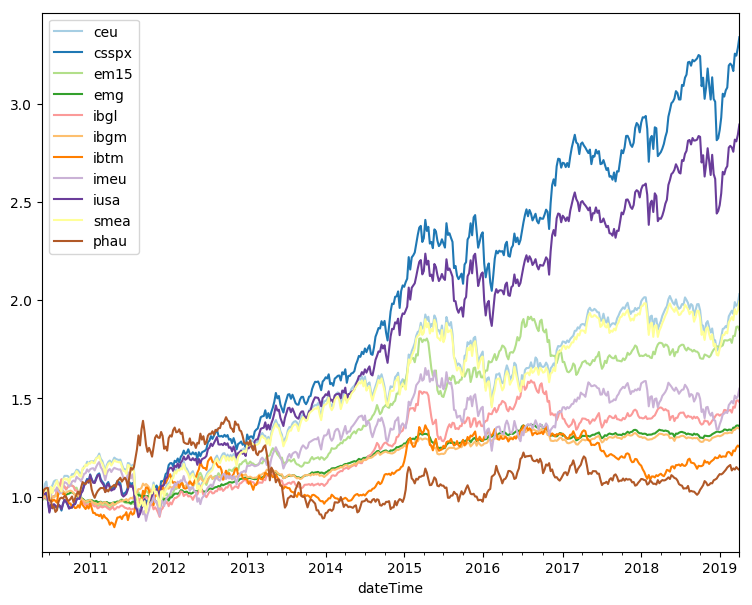

In [52]:
plt.style.use('default')
#norm_df200.plot(kind='line', colormap='PiYG')
#norm_df200.plot(kind='line', colormap='inferno')
norm_df200.plot(kind='line', colormap='Paired', figsize=(9,7))

### Returns

In [53]:
returns = np.log(df200/df200.shift(1))
returns.dropna(inplace=True)

In [54]:
PERIODS = 52
stats = pd.DataFrame()
stats['Annualized Returns(%)'] = returns.mean() * PERIODS *100
stats['Annualized Volatility(%)'] = returns.std() * np.sqrt(PERIODS)*100
stats['Sharpe Ratio'] = stats['Annualized Returns(%)'] /stats['Annualized Volatility(%)']
print(82*'-')
print('Assets Classes Annualized Statistics — full observation period')
stats.style.bar(color=['red','green'], align='zero')

----------------------------------------------------------------------------------
Assets Classes Annualized Statistics — full observation period


,Annualized Returns(%),Annualized Volatility(%),Sharpe Ratio
ceu,7.97296,15.0754,0.528871
csspx,13.5652,14.4718,0.937359
em15,6.91398,9.3092,0.742704
emg,3.45551,3.9893,0.866195
ibgl,4.42309,9.10413,0.485833
ibgm,3.34527,4.68334,0.714291
ibtm,2.54402,10.5114,0.242026
imeu,4.92916,15.1246,0.325904
iusa,11.9572,14.6949,0.813701
smea,7.76672,15.2608,0.508931


In [55]:
returns.corr('pearson')

,ceu,csspx,em15,emg,ibgl,ibgm,ibtm,imeu,iusa,smea,phau
ceu,1.000000,0.749351,-0.042565,0.081094,-0.048725,-0.107565,-0.187910,0.950445,0.754046,0.928445,-0.042402
csspx,0.749351,1.000000,-0.038044,0.017374,-0.036761,-0.034124,0.164968,0.795790,0.994142,0.775686,0.055696
em15,-0.042565,-0.038044,1.000000,0.887915,0.944753,0.784444,0.371427,-0.045236,-0.039452,-0.051044,0.158376
emg,0.081094,0.017374,0.887915,1.000000,0.877595,0.786720,0.289836,0.070634,0.017809,0.074586,0.156645
ibgl,-0.048725,-0.036761,0.944753,0.877595,1.000000,0.839189,0.411213,-0.044561,-0.039823,-0.064618,0.157914
ibgm,-0.107565,-0.034124,0.784444,0.786720,0.839189,1.000000,0.558391,-0.097987,-0.040794,-0.108649,0.242127
ibtm,-0.187910,0.164968,0.371427,0.289836,0.411213,0.558391,1.000000,-0.166197,0.157062,-0.171793,0.350912
imeu,0.950445,0.795790,-0.045236,0.070634,-0.044561,-0.097987,-0.166197,1.000000,0.799958,0.960064,-0.021770
iusa,0.754046,0.994142,-0.039452,0.017809,-0.039823,-0.040794,0.157062,0.799958,1.000000,0.783636,0.062149
smea,0.928445,0.775686,-0.051044,0.074586,-0.064618,-0.108649,-0.171793,0.960064,0.783636,1.000000,-0.000993


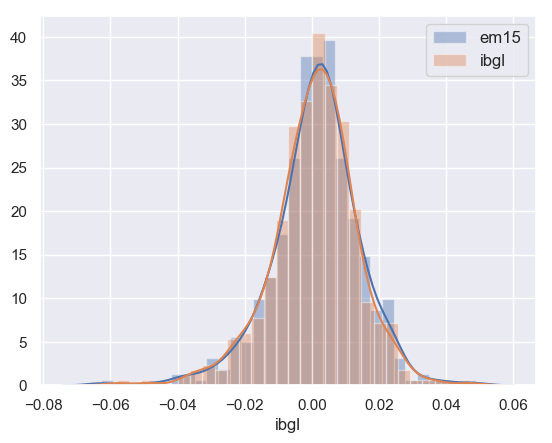

In [56]:
sns.set()

fig4 = plt.figure()
#sns.distplot(returns['ibtm'])
sns.distplot(returns['em15'])
sns.distplot(returns['ibgl'])
#plt.legend(('ibtm','em15','ibgm'),fontsize = 12)
plt.legend(('em15','ibgl'),fontsize = 12)
plt.show()


## Portfolio allocation(s)

#### Preparo la matrice delle allocations

In [57]:
allocation = pd.DataFrame(index=norm_df200.columns)
allocation['ticker'] = allocation.index + '.MI'
allocation.ticker = allocation.ticker.str.upper()

df4ri = df4.set_index('ticker')
def myfunc(row):
    return df4ri.loc[row.ticker,'areaBenchmark']

allocation['area'] = allocation.apply(myfunc, axis=1)

allocation['one'] = 0
allocation['two'] = 0

allocation


,ticker,area,one,two
ceu,CEU.MI,AZIONARIO EUROPA - AREA,0,0
csspx,CSSPX.MI,AZIONARIO NORD AMERICA,0,0
em15,EM15.MI,TITOLI DI STATO - EURO,0,0
emg,EMG.MI,TITOLI DI STATO - EURO,0,0
ibgl,IBGL.MI,TITOLI DI STATO - EURO,0,0
ibgm,IBGM.MI,TITOLI DI STATO - EURO,0,0
ibtm,IBTM.MI,TITOLI DI STATO - NON EURO,0,0
imeu,IMEU.MI,AZIONARIO EUROPA - AREA,0,0
iusa,IUSA.MI,AZIONARIO NORD AMERICA,0,0
smea,SMEA.MI,AZIONARIO EUROPA - AREA,0,0


#### setup allocazioni

In [111]:
# one
allocation.loc['iusa','one'] = 0.2
allocation.loc['smea','one'] = 0.2
allocation.loc['phau','one'] = 0.1
allocation.loc['em15','one'] = 0.2
allocation.loc['ibtm','one'] = 0.3
# two
allocation.loc['iusa','two'] = 0.3
allocation.loc['smea','two'] = 0.2
allocation.loc['phau','two'] = 0.1
allocation.loc['em15','two'] = 0.3
allocation.loc['ibtm','two'] = 0.1

In [59]:
#norm_df200.ceu.plot()
#norm_df200.smea.plot()
#norm_df200.imeu.plot()
#plt.legend()

#norm_df200.em15.plot()
#norm_df200.ibgl.plot()
#norm_df200.emg.plot()
#plt.legend()

In [60]:
lEtfs = allocation[allocation.one != 0].index.tolist()

In [61]:
allocation_restr = allocation[allocation.one != 0]
allocation_restr

,ticker,area,one,two
em15,EM15.MI,TITOLI DI STATO - EURO,0.2,0.3
ibtm,IBTM.MI,TITOLI DI STATO - NON EURO,0.3,0.1
iusa,IUSA.MI,AZIONARIO NORD AMERICA,0.2,0.3
smea,SMEA.MI,AZIONARIO EUROPA - AREA,0.2,0.2
phau,PHAU.MI,METALLI PREZIOSI,0.1,0.1


### Calcolo rendimento di due portafogli "miei" - no rebalancing

In [62]:
norm_df201 = norm_df200.copy()

In [63]:
norm_df201['one'] = norm_df200.mul(allocation.one.values,axis=1).sum(axis=1)
norm_df201['two'] = norm_df200.mul(allocation.two.values,axis=1).sum(axis=1)

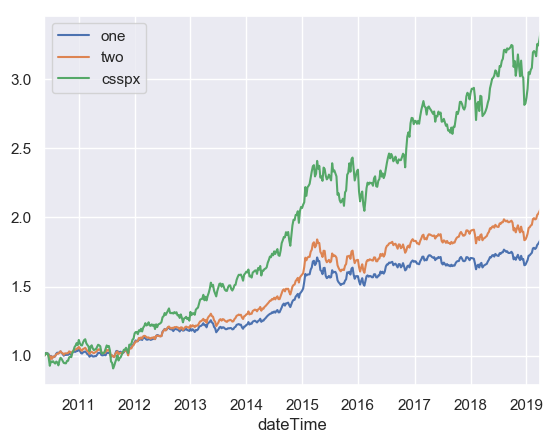

In [64]:
norm_df201.one.plot()
norm_df201.two.plot()
norm_df201.csspx.plot()  # per confronto, plotto il sp500
plt.legend()


In [65]:
exp_ret_one = np.sum(returns.mean()* allocation.one)* PERIODS
exp_std_one = np.sqrt(np.dot(allocation.one.T,np.dot(returns.cov()*PERIODS, allocation.one)))
sharpe_one = exp_ret_one/exp_std_one

exp_ret_two = np.sum(returns.mean()* allocation.two)* PERIODS
exp_std_two = np.sqrt(np.dot(allocation.two.T,np.dot(returns.cov()*PERIODS, allocation.two)))
sharpe_two = exp_ret_two/exp_std_two

print('Key Stats: Portfolio one')
print(82*'=')
print('Annualized Returns: {:.3%}'.format(exp_ret_one))
print('Annualized Volatility: {:.3%}'.format(exp_std_one))
print('Sharpe Ratio: {:.4}'.format(sharpe_one))
print(82*'-')
print('Key Stats: Portfolio two ')
print(82*'=')
print('Annualized Returns: {:.3%}'.format(exp_ret_two))
print('Annualized Volatility: {:.3%}'.format(exp_std_two))
print('Sharpe Ratio: {:.4}'.format(sharpe_two))
print(82*'-')

Key Stats: Portfolio one
Annualized Returns: 6.235%
Annualized Volatility: 7.417%
Sharpe Ratio: 0.8407
----------------------------------------------------------------------------------
Key Stats: Portfolio two 
Annualized Returns: 7.613%
Annualized Volatility: 8.039%
Sharpe Ratio: 0.947
----------------------------------------------------------------------------------


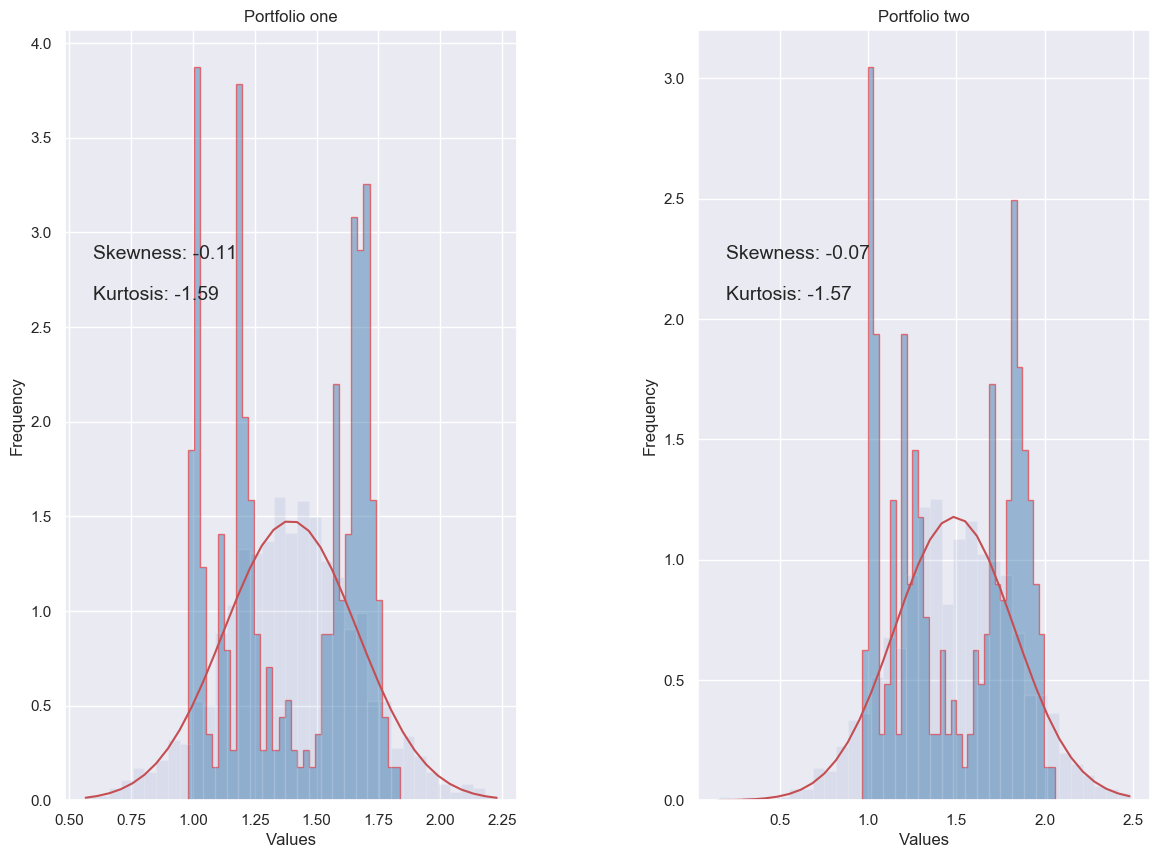

In [66]:
binsnumber = 35
fig7, ax = plt.subplots(figsize=(14,10))
plt.subplots_adjust(hspace=.4,wspace=.4) # it adds space in between plots
plt.subplot(121)
ax = plt.gca()

ax.hist(norm_df201['one'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = norm_df201['one'].std(),norm_df201['one'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(norm_df201['one'].skew(),2),round(norm_df201['one'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,360),fontsize=14)


ax.set_xlabel('Values')
ax.set_ylabel('Frequency')
ax.set_title('Portfolio one')

plt.subplot(122)
ax1 = plt.gca()

ax1.hist(norm_df201['two'], bins=binsnumber, color='steelblue', density = True,
       alpha = 0.5, histtype ='stepfilled',edgecolor ='red' )

sigma, mu = norm_df201['two'].std(),norm_df201['two'].mean() # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, binsnumber, density=True, alpha = 0.1)
ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=1.5, color='r')

ax1.annotate('Skewness: {}\n\nKurtosis: {}'.format(round(norm_df201['two'].skew(),2),round(norm_df201['two'].kurtosis(),2)),
             xy=(10,20),xycoords = 'axes points',xytext =(20,360),fontsize=14)


ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')
ax1.set_title('Portfolio two')

plt.show();

## Montecarlo

In [67]:
allocation_restr

,ticker,area,one,two
em15,EM15.MI,TITOLI DI STATO - EURO,0.2,0.3
ibtm,IBTM.MI,TITOLI DI STATO - NON EURO,0.3,0.1
iusa,IUSA.MI,AZIONARIO NORD AMERICA,0.2,0.3
smea,SMEA.MI,AZIONARIO EUROPA - AREA,0.2,0.2
phau,PHAU.MI,METALLI PREZIOSI,0.1,0.1


In [68]:
myrets = np.array([exp_ret_one, exp_ret_two])
myvols = np.array([exp_std_one, exp_std_two])

In [69]:
lista = lEtfs.copy()
lista.append('returns')
lista.append('volatility')
lista.append('sharpe')

monte_df = pd.DataFrame(columns=lista)
for p in range(2500):
    weights = np.random.random(len(allocation_restr))
    weights /= np.sum(weights)

    ret = np.sum(returns[lEtfs].mean()*PERIODS*weights)
    vol = np.sqrt(np.dot(weights.T, np.dot(returns[lEtfs].cov()*PERIODS, weights)))
    #monte_df.loc[p] = pandas.Series({'a':1, 'b':5, 'c':2, 'd':3})
    sharpe = ret / vol

    ww = weights.tolist()
    ww.append(ret)
    ww.append(vol)
    ww.append(sharpe)

    monte_df.loc[p] = ww


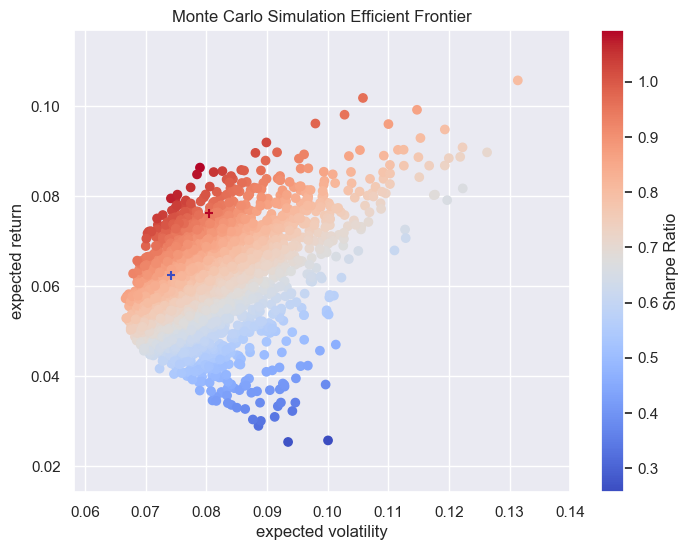

In [70]:
fig9 = plt.figure(figsize = (8,6))

plt.scatter(monte_df.volatility, monte_df.returns, 
            c = monte_df.sharpe, 
            marker = 'o', cmap='coolwarm')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe Ratio')
plt.title('Monte Carlo Simulation Efficient Frontier')

plt.scatter(myvols, myrets, c = myrets / myvols, marker = '+', cmap='coolwarm')

plt.show();

In [71]:
monte_df.head()

,em15,ibtm,iusa,smea,phau,returns,volatility,sharpe
0,0.563631,0.160876,0.221648,0.052155,0.001689,0.073640,0.072013,1.022592
1,0.346115,0.212033,0.188225,0.230856,0.022772,0.070089,0.073798,0.949748
2,0.104136,0.226917,0.060605,0.310939,0.297403,0.048657,0.078614,0.618932
3,0.146630,0.280474,0.316796,0.037699,0.218401,0.061230,0.079044,0.774627
4,0.205320,0.299801,0.110022,0.349137,0.035721,0.062610,0.076761,0.815644


In [72]:
monte_df.iloc[monte_df.sharpe.idxmax()]

em15          0.487765
ibtm          0.068048
iusa          0.418610
smea          0.007197
phau          0.018380
returns       0.086333
volatility    0.078956
sharpe        1.093441
Name: 918, dtype: float64

In [149]:
monte_df.iloc[monte_df.volatility.idxmin()]

em15          0.395800
ibtm          0.257837
iusa          0.006590
smea          0.262404
phau          0.077370
returns       0.056208
volatility    0.066693
sharpe        0.842791
Name: 1989, dtype: float64

## Montecarlo 2 - calcolo efficient frontier

In [13]:
from montecarlo import *

In [7]:
assets_all = ['imeu','ceu','smea','iusa','csspx','phau','ibtm','ibgm', 'emg', 'em15', 'ibgl']
assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau']
numAssets = len(assets)
PERIODS = 252
dur = 20
riskFreeRate = 0.01

In [9]:
data = df102.copy()  # daily quotes assets_all

## LOG *DAILY* returns
returns = np.log(data/data.shift(1))
returns.dropna(inplace=True)

meanDailyReturns = returns[assets].mean()
covMatrix = returns[assets].cov()
meanDailyReturns

/Users/simo/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


em15    0.000273
ibtm    0.000095
iusa    0.000471
smea    0.000307
phau    0.000049
dtype: float64

In [10]:

## TEST su 2 portafogli disegnati da me

# assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau']
weights = np.array([0.2,0.3,0.2,0.2,0.1])
weights = np.array([0.3,0.1,0.3,0.2,0.1])

calcPortfolioPerf(weights, meanDailyReturns, covMatrix, PERIODS)


(0.0752584718526122, 0.07851621302124394)

In [11]:
#Run MC simulation of numPortfolios portfolios

numPortfolios = 2500
results = np.zeros((3,numPortfolios))

#Calculate portfolios

for i in range(numPortfolios):
    #Draw numAssets random numbers and normalize them to be the portfolio weights

    weights = np.random.random(numAssets)
    weights /= np.sum(weights)

    #Calculate expected return and volatility of portfolio

    pret, pvar = calcPortfolioPerf(weights, meanDailyReturns, covMatrix, PERIODS)

    #Convert results to annual basis, calculate Sharpe Ratio, and store them

    results[0,i] = pret
    results[1,i] = pvar
    results[2,i] = (results[0,i] - riskFreeRate)/results[1,i]

In [14]:
maxPtfls = pd.DataFrame(columns=['ret','vola'])

#Find portfolio with maximum Sharpe ratio
maxSharpe = findMaxSharpeRatioPortfolio( meanDailyReturns, covMatrix,
                                        riskFreeRate, PERIODS)
rp, sdp = calcPortfolioPerf(maxSharpe['x'], meanDailyReturns, covMatrix, PERIODS)
a0 = np.array([rp, sdp])
maxPtfls.loc[0] = a0

#Find portfolio with minimum variance
minVar = findMinVariancePortfolio(meanDailyReturns, covMatrix, PERIODS)
rp, sdp = calcPortfolioPerf(minVar['x'], meanDailyReturns, covMatrix, PERIODS)
a1 = np.array([rp, sdp])
maxPtfls.loc[1] = a1

In [15]:
#targetReturns = np.linspace(0.09, 0.16, 50)/(252./dur)
targetReturns = np.linspace(0.02, 0.12, 20)
efficientPortfolios = findEfficientFrontier(meanDailyReturns, covMatrix, targetReturns, PERIODS)

In [16]:
### PLOTTING

dfResults = pd.DataFrame(results.T)
dfResults.columns = ['ret','vola','sharpe']

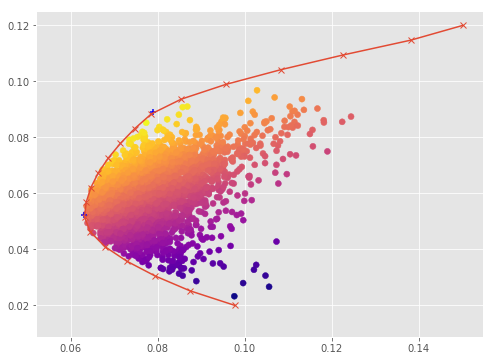

In [17]:
fig10 = plt.figure(figsize = (8,6))


plt.scatter(dfResults.vola, dfResults.ret, c = dfResults.sharpe, 
            marker = 'o', cmap='plasma')

plt.scatter(maxPtfls.vola, maxPtfls.ret, c='blue', marker = '+')

plt.plot([p['fun'] for p in efficientPortfolios], 
         targetReturns, marker='x')

plt.show();


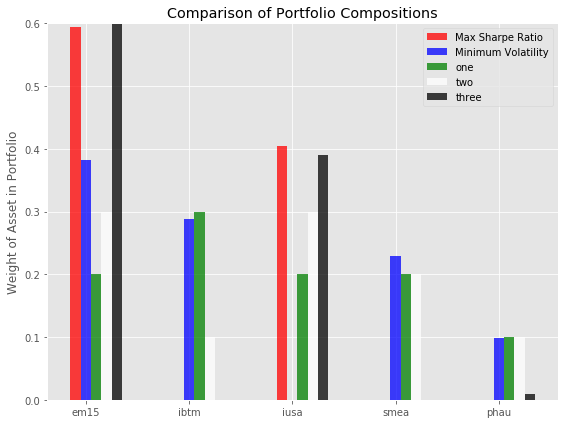

In [23]:
#plt.figure(figsize=(8,6))
ind = np.arange(numAssets)
width = 0.1
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(ind, maxSharpe['x'], width, color='r', alpha=0.75)
rects2 = ax.bar(ind + width, minVar['x'], width, color='b', alpha=0.75)
rects3 = ax.bar(ind + 2*width,np.array([0.2,0.3,0.2,0.2,0.1]), width, color='g', alpha=0.75)
rects4 = ax.bar(ind + 3*width,np.array([0.3,0.1,0.3,0.2,0.1]), width, color='w', alpha=0.75)
rects5 = ax.bar(ind + 4*width,np.array([0.6,0.0,0.39,0.0,0.01]), width, color='black', alpha=0.75)

ax.set_ylabel('Weight of Asset in Portfolio')
ax.set_ylim(0,0.6)
ax.set_title('Comparison of Portfolio Compositions')
ax.set_xticks(ind + width)
ax.set_xticklabels(assets)
plt.tight_layout()
ax.legend((rects1[0], rects2[0],rects3[0],rects4[0],rects5[0]), 
          ('Max Sharpe Ratio', 'Minimum Volatility','one','two','three'))
#plt.savefig('Portfolio Compositions', dpi=100)
plt.show()

In [24]:
maxSharpe.x, minVar.x

(array([5.94914313e-01, 0.00000000e+00, 4.05085687e-01, 2.38524478e-18,
        2.00577402e-17]),
 array([3.83007531e-01, 2.88741944e-01, 1.77538106e-18, 2.29808545e-01,
        9.84419797e-02]))

In [25]:
# controprova
# assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau']
weights = np.array([0.6,0.0,0.39,0.0,0.01])

calcPortfolioPerf(weights, meanDailyReturns, covMatrix, PERIODS)



(0.08760526737914795, 0.0779583219455764)

In [26]:
calcPortfolioPerf(maxSharpe.x, meanDailyReturns, covMatrix, PERIODS)

(0.08892287237732538, 0.07905197435427133)

In [27]:
calcPortfolioPerf(minVar.x, meanDailyReturns, covMatrix, PERIODS)

(0.052170015365243, 0.06319572034324648)

In [28]:
## plot storico portafogli
# assets = ['em15', 'ibtm', 'iusa', 'smea', 'phau']
mydata = data[assets]
ndata = mydata/mydata.iloc[0]
pndata = ndata.copy()

weights = np.array([0.2,0.3,0.2,0.2,0.1])
pndata['one'] = ndata.mul(weights,axis=1).sum(axis=1)

weights = np.array([0.3,0.1,0.3,0.2,0.1])
pndata['two'] = ndata.mul(weights,axis=1).sum(axis=1)

weights = np.array([0.6,0.0,0.39,0.0,0.01])
pndata['three'] = ndata.mul(weights,axis=1).sum(axis=1)

weights = minVar['x']
pndata['minvar'] = ndata.mul(weights,axis=1).sum(axis=1)

weights = maxSharpe['x']
pndata['maxSharpe'] = ndata.mul(weights,axis=1).sum(axis=1)


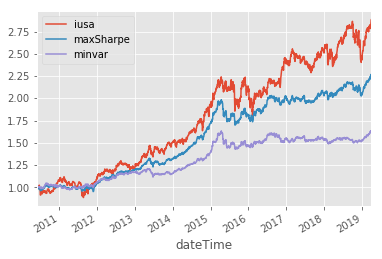

In [29]:
pndata.iusa.plot()
pndata.maxSharpe.plot()
pndata.minvar.plot()
plt.legend()

In [30]:
data.head()

,ceu,csspx,em15,emg,ibgl,ibgm,ibtm,imeu,iusa,smea,phau
dateTime,,,,,,,,,,,
2010-05-26,110.85,75.49,124.35,134.45,162.99,161.72,141.00,15.255,8.8475,25.81,98.28
2010-05-27,110.85,75.52,124.58,133.98,161.57,161.30,139.60,15.575,8.8450,25.81,97.70
2010-05-28,110.85,75.35,124.28,134.13,162.20,161.05,139.23,15.705,8.8225,25.81,96.45
2010-05-31,110.85,75.84,124.02,134.63,162.49,161.53,139.77,15.745,8.8400,25.81,97.94
2010-06-01,110.85,75.49,123.95,134.53,162.13,161.87,140.00,15.560,8.8225,25.81,98.74


In [31]:
pndata.head()

,em15,ibtm,iusa,smea,phau,one,two,three,minvar,maxSharpe
dateTime,,,,,,,,,,
2010-05-26,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2010-05-27,1.001850,0.990071,0.999717,1.0,0.994098,0.996745,0.998887,1.000941,0.997261,1.000986
2010-05-28,0.999437,0.987447,0.997174,1.0,0.981380,0.993694,0.995866,0.998374,0.994327,0.998520
2010-05-31,0.997346,0.991277,0.999152,1.0,0.996540,0.996337,0.997731,0.998043,0.996124,0.998078
2010-06-01,0.996783,0.992908,0.997174,1.0,1.004681,0.997132,0.997946,0.997015,0.997181,0.996942


In [41]:
pndata.to_csv('norm_portfolio_data.csv')

In [32]:
returns.head()

,ceu,csspx,em15,emg,ibgl,ibgm,ibtm,imeu,iusa,smea,phau
dateTime,,,,,,,,,,,
2010-05-27,0.00000,0.000397,0.001848,-0.003502,-0.008750,-0.002600,-0.009979,0.020760,-0.000283,0.000000,-0.005919
2010-05-28,0.00000,-0.002254,-0.002411,0.001119,0.003892,-0.001551,-0.002654,0.008312,-0.002547,0.000000,-0.012877
2010-05-31,0.00000,0.006482,-0.002094,0.003721,0.001786,0.002976,0.003871,0.002544,0.001982,0.000000,0.015330
2010-06-01,0.00000,-0.004626,-0.000565,-0.000743,-0.002218,0.002103,0.001644,-0.011819,-0.001982,0.000000,0.008135
2010-06-02,0.01921,-0.001989,-0.001292,-0.002456,-0.005753,-0.003900,0.007756,0.009912,-0.000850,0.024116,-0.000608


In [33]:
portfolio_returns = np.log(pndata/pndata.shift(1))
portfolio_returns.dropna(inplace=True)

In [34]:
portfolio_returns.head()

,em15,ibtm,iusa,smea,phau,one,two,three,minvar,maxSharpe
dateTime,,,,,,,,,,
2010-05-27,0.001848,-0.009979,-0.000283,0.000000,-0.005919,-0.003261,-0.001114,0.000940,-0.002743,0.000985
2010-05-28,-0.002411,-0.002654,-0.002547,0.000000,-0.012877,-0.003065,-0.003029,-0.002567,-0.002946,-0.002466
2010-05-31,-0.002094,0.003871,0.001982,0.000000,0.015330,0.002656,0.001871,-0.000332,0.001806,-0.000443
2010-06-01,-0.000565,0.001644,-0.001982,0.000000,0.008135,0.000798,0.000215,-0.001030,0.001060,-0.001139
2010-06-02,-0.001292,0.007756,-0.000850,0.024116,-0.000608,0.006710,0.004951,-0.001113,0.007283,-0.001113


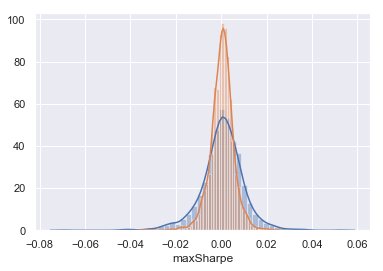

In [164]:
sns.set()

fig4 = plt.figure()
#sns.distplot(returns['ibtm'])
sns.distplot(portfolio_returns.iusa)
sns.distplot(portfolio_returns.maxSharpe)
#sns.distplot(portfolio_returns.phau)
#plt.legend(('ibtm','em15','ibgm'),fontsize = 12)
#plt.legend(('em15','ibgl'),fontsize = 12)

plt.show()


#### Calcolo DD e MDD

In [126]:
roll_max = pndata.rolling(PERIODS, min_periods=1).max()
dailydd = pndata/roll_max - 1.0
max_dailydd = dailydd.rolling(PERIODS, min_periods=1).min()

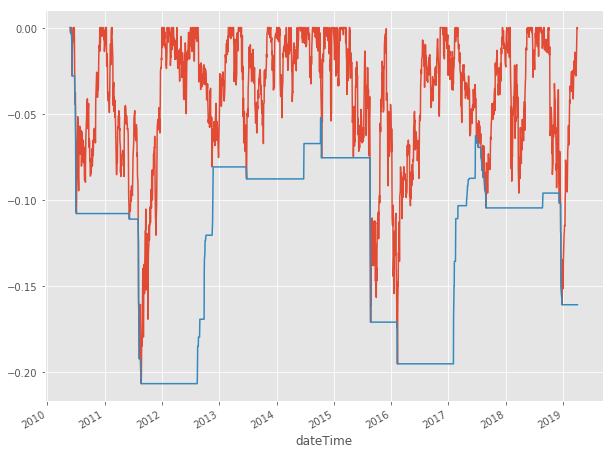

In [135]:
dailydd.iusa.plot(figsize=(10,8))
max_dailydd.iusa.plot()

In [35]:
def calculate_max_drawdown(ndata):
    Roll_Max = ndata.cummax()
    Daily_Drawdown = ndata/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    max_drawdown = Max_Daily_Drawdown.min() * -1.0
    return max_drawdown

calculate_max_drawdown(pndata)

em15         0.174907
ibtm         0.210625
iusa         0.206879
smea         0.261869
phau         0.371762
one          0.135543
two          0.149029
three        0.142955
minvar       0.124957
maxSharpe    0.143394
dtype: float64

# TESTs

In [ ]:
datos_returns = np.log(datos/datos.shift(1))
datos_returns.dropna(inplace=True)
stats = pd.DataFrame()
stats[‘Annualized Returns(%)’] =datos_returns.mean() * semana *100
stats[‘Annualized Volatility(%)’] = datos_returns.std() * np.sqrt(semana)*100
stats[‘Sharpe Ratio’] = stats[‘Annualized Returns(%)’] /stats[‘Annualized Volatility(%)’]
print(82*’-’)
print(‘Assets Classes Annualized Statistics — full observation period’)
stats.style.bar(color=[‘red’,’green’], align=’zero’)

In [ ]:
f = plt.figure()
plt.title('Title here!', color='black')
dfLista.ceu.plot(kind='line', ax=f.gca())
dfLista.imeu.plot(kind='line', ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()



In [ ]:
z.loc[mask,'end_date'] = z[mask].apply(lambda x: correct_end_date(x['ticker'],x['isin']), axis=1)

In [ ]:
z[mask]

In [ ]:
def myfunc(ticker, isin):
    return str(ticker)+str(isin)

z.loc[mask,'end_date'] = z.apply(lambda x: myfunc(x['isin'],x['ticker']), axis=1)

### Test lettura quotazioni ETF da ./csv/

In [ ]:
tickers = ['A500.MI']

In [ ]:
ticker_file = WORKDIR + tickers[0] + EXT

#df = pd.read_csv(ticker_file, index_col=1, parse_dates=True)
df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)

In [ ]:
df.head()

In [ ]:
end = df.index[df.shape[0]-1]
start = df.index[0]

end - start
end.date()

np.busday_count( start.date(), end.date() )

### correzioni

In [ ]:
tickers = ['EUE.MI']

In [ ]:
ticker_file = WORKDIR + tickers[0] + EXT

#df = pd.read_csv(ticker_file, index_col=1, parse_dates=True)
df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)

In [ ]:
df.loc['2018-11-21','high'] = 31.98
df.loc['2018-11-21','low'] = 31.69
df.loc['2018-11-21','close'] = 31.96



In [ ]:
df.close.plot(figsize=(16, 10))

### apply colonne multiple

In [ ]:
df100 = dfEtfInfo

In [ ]:
def myfunc(isin, ticker):
    return str(isin)+str(ticker)

df100['newcolumn'] = df100.apply(lambda x: myfunc(x['isin'],x['ticker']), axis=1)

In [ ]:
df100.head()

### leggi ticker.mi csv altrimenti isin.csv

In [ ]:
def get_start_date(isin, ticker):
    try:
        ticker_file = WORKDIR + ticker + EXT
        df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True)
        end = df.index[df.shape[0]-1]
        start = df.index[0]
        return start
    except FileNotFoundError:
        try:
            ticker_file = WORKDIR + isin + EXT
            df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True)
            end = df.index[df.shape[0]-1]
            start = df.index[0]
            return start
        except FileNotFoundError:
            return None

def get_end_date(isin, ticker):
    try:
        ticker_file = WORKDIR + ticker + EXT
        df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True)
        end = df.index[df.shape[0]-1]
        start = df.index[0]
        return end
    except FileNotFoundError:
        try:
            ticker_file = WORKDIR + isin + EXT
            df = pd.read_csv(ticker_file, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True)
            end = df.index[df.shape[0]-1]
            start = df.index[0]
            return end
        except FileNotFoundError:
            return None

In [ ]:
df100 = dfEtfInfo[dfEtfInfo.areaBenchmark == 'AZIONARIO NORD AMERICA']

df101 = df3[df3.benchmark == 'S&P 500 TRN USD']

df101['start_date'] = df101.apply(lambda x: get_start_date(x['isin'],x['ticker']), axis=1)
df101['end_date'] = df101.apply(lambda x: get_end_date(x['isin'],x['ticker']), axis=1)

In [ ]:
df101.head()

### Lista le aree degli ETF

In [ ]:
aree = pd.DataFrame(dfEtfInfo.areaBenchmark.unique(),columns=['areaBenchmark'])
aree.sort_values(by='areaBenchmark',inplace=True)

aree

In [ ]:
df3 = dfEtfInfo[dfEtfInfo.areaBenchmark == 'AZIONARIO NORD AMERICA']

In [ ]:
df3[df3.benchmark == 'S&P 500 TRN USD']

In [ ]:
df4 = df3[df3.benchmark == 'S&P 500 TRN USD']
# df5 = df4.assign(startDate=df4.ticker.apply(get_start_date),endDate=df4.ticker.apply(get_end_date))

In [ ]:
df4['startDate'] = df4.ticker.apply(get_start_date)
df4['endDate'] = df4.ticker.apply(get_end_date)
    
    

In [ ]:
def myfunc100(row):
    return pd.Series(['PIP','PO'])


dfEtfInfo[['test1', 'test2']] = dfEtfInfo.apply(myfunc100, axis=1)

In [ ]:
dfEtfInfo = pd.read_excel('infoprovider_etc.xlsx').iloc[6:,:]
dfEtfInfo.columns = dfEtfInfo.iloc[0,:].tolist()
dfEtfInfo = dfEtfInfo.iloc[1:,:]
dfEtfInfo.set_index('N.',inplace=True)
# df2['Strumento'].unique()
# df2.drop(df2[df2['Strumento'] == 0].index, inplace=True) # pulisce
dfEtfInfo = dfEtfInfo[dfEtfInfo['Strumento'] == 'ETF']
dfEtfInfo = dfEtfInfo[['ISIN','Nome','Reuters RIC (Italy)','Indice Benchmark','TER','Area Benchmark','Emittente']]
dfEtfInfo.columns = ['isin','nome','ticker','benchmark','ter','areaBenchmark','emittente']
# df2.set_index('ticker', inplace=True)

In [ ]:
dfEtcInfo

In [ ]:
ceu = pd.read_csv('csv/CEU.MI.csv', usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)
imeu = pd.read_csv('csv/IMEU.MI.csv', usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)
tmp1 = ceu.join(imeu, how='outer', rsuffix='_1')[['close','close_1']]
tmp1.columns=['ceu','imeu']
tmp1


In [ ]:
df5 = pd.DataFrame()

for index,row in df4.iterrows():
    ticker = row.ticker
    source = row.dataSource
    filename = WORKDIR + source + EXT
    tmpdf = pd.read_csv(filename, usecols=[1,2,3,4,5,6], index_col=0, parse_dates=True, dayfirst=True)
    df5[ticker] = tmpdf.close
